In [704]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from tensorflow.keras.optimizers import Adam

In [705]:
inputs_train = pd.read_csv("../../data/cleaned/unemp_inputs_train_det.csv")
inputs_train = inputs_train.drop(columns=["id"], axis=1)

samples_train, features = inputs_train.shape 

labels_train = pd.read_csv("../../data/cleaned/unemp_labels_train_det.csv")
labels_train = labels_train.drop(columns=["id"], axis=1)

inputs_test = pd.read_csv("../../data/cleaned/unemp_inputs_test_det.csv")
inputs_test = inputs_test.drop(columns=["id"], axis=1)

samples_test, features = inputs_test.shape 

labels_test = pd.read_csv("../../data/cleaned/unemp_labels_test_det.csv")
labels_test = labels_test.drop(columns=["id"], axis=1)

print(samples_train, samples_test)

615 145


In [706]:
# generates timestepped data for autorregression

def generate_timesteps(data, ind=1, out=1):
    cols, col_names = [], []
    
    if type(data) is list:
        vars = 1 
    else:
        vars = data.shape[1]
    df = pd.DataFrame(data)
    
    # input sequence of t-n to t-1
    for i in range(ind, 0, -1):
        cols.append(df.shift(i))
        col_names += [('var%d(t-%d)' % (j + 1, i)) for j in range(vars)]

    # forecast sequence of t to t+n
    for i in range(0, out):
        cols.append(df.shift(-i))
        if i == 0:
            col_names += [('var%d(t)' % (j + 1)) for j in range(vars)]
        else:
            col_names += [('var%d(t+%d)' % (j + 1, i)) for j in range(vars)]

    timestepped = pd.concat(cols, axis=1)
    timestepped.columns = col_names
    timestepped.dropna(inplace=True)
    return timestepped

In [707]:
# process data for autoregression

window_train = 1
window_test = 1

train_in, test_in = samples_train-window_train, samples_test-window_test

inputs_train = generate_timesteps(inputs_train.values, train_in, window_train)
print(inputs_train.shape)

inputs_test = generate_timesteps(inputs_test.values, test_in, window_test)
print(inputs_test.shape)

# roll by window size

inputs_train = inputs_train.rolling(window=window_train).mean().dropna()
inputs_test = inputs_test.rolling(window=window_test).mean().dropna()

(1, 74415)
(1, 17545)


In [708]:
# 3d shapes for feeding to AR-LSTM
inputs_train_shape = (samples_train, samples_train-train_in, features)
inputs_test_shape = (samples_test, samples_test-test_in, features)

inputs_train = inputs_train.values.reshape(inputs_train_shape)
inputs_test = inputs_test.values.reshape(inputs_test_shape)

print('inputs_train:', inputs_train.shape, 'labels_train:', labels_train.shape, 
      '\ninputs_test:', inputs_test.shape, 'labels_test:', labels_test.shape)

inputs_train: (615, 1, 121) labels_train: (615, 1) 
inputs_test: (145, 1, 121) labels_test: (145, 1)


In [709]:
def fit(n_neurons=50, batch_size=50, epochs=5, optimizer='adam', verbosity=2):
    ARNN = Sequential(layers=[LSTM(n_neurons, input_shape=(inputs_train.shape[1], inputs_train.shape[2])), 
    Dense(1)])
    ARNN.compile(loss='mae', optimizer=optimizer, metrics=['mse'])

    history = ARNN.fit(inputs_train, labels_train, epochs=epochs, batch_size=batch_size, verbose=verbosity)
    
    return (ARNN, history)

ARNN, history = fit()

Epoch 1/5
13/13 - 2s - loss: 0.4067 - mse: 0.1850 - 2s/epoch - 116ms/step
Epoch 2/5
13/13 - 0s - loss: 0.2556 - mse: 0.0864 - 29ms/epoch - 2ms/step
Epoch 3/5
13/13 - 0s - loss: 0.1361 - mse: 0.0319 - 30ms/epoch - 2ms/step
Epoch 4/5
13/13 - 0s - loss: 0.1018 - mse: 0.0180 - 29ms/epoch - 2ms/step
Epoch 5/5
13/13 - 0s - loss: 0.1033 - mse: 0.0178 - 26ms/epoch - 2ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


test loss: 0.15936149656772614
test MSE: 0.03854857757687569


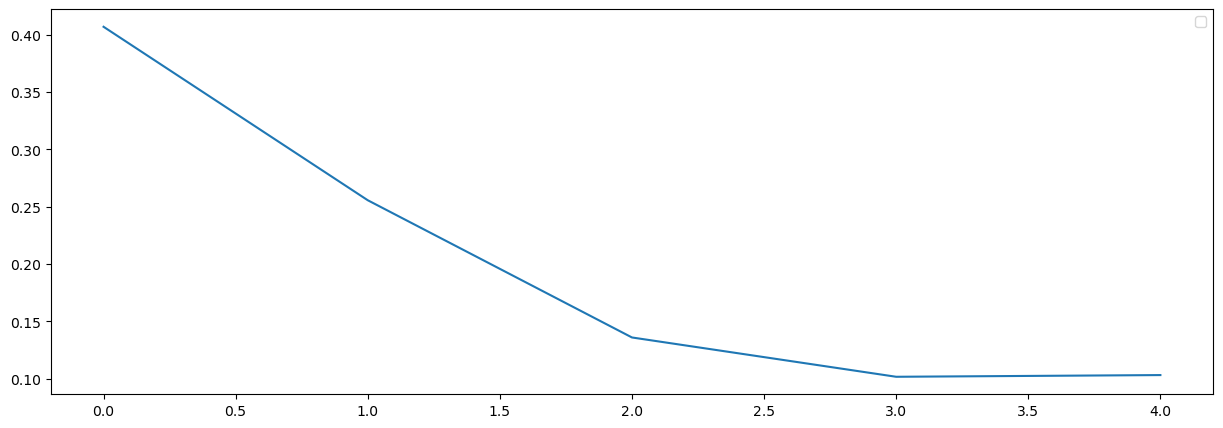

In [710]:
loss, mse = ARNN.evaluate(inputs_test, labels_test, verbose=0)
print('test loss:', loss)
print('test MSE:', mse)

# plot history
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.legend()
plt.show()

In [711]:
y_pred_out = model_lstm.predict(inputs_train)

#=======================================================  inverting scaling
def inverting(series, ls=-1):
    return scaler.inverse_transform(np.concatenate((reframed_test.values[:, :ls], series), axis=1))[:, -1]

y_pred_lstm_E = inverting(y_pred_out)
y_inv = inverting(y_test.values.reshape(y_test.shape[0], 1))

#======================================================= metrics
# calculate RMSE
rmse_lstm = tf.math.sqrt(MSE(y_inv, y_pred_lstm_E))
print('Test RMSE: %.3f' % rmse_lstm)

# calculate model accuracy
accuracy_lstm = r2_score(y_inv, y_pred_lstm_E)
print('Model accuracy: {:.3f}'.format(accuracy_lstm))

# calculate mean directional accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) 
                    == np.sign(predicted[1:] - predicted[:-1])).astype(int))
mda_lstm = mda(y_inv, y_pred_lstm_E)

print('Model Mean Directional accuracy: {:.3f}'.format(mda_lstm))

NameError: name 'reframed_test' is not defined

In [ ]:
hours_df = reframed_test.index
plt.figure(figsize=(15, 5))
plt.plot(hours_df, y_inv, label='Consumption')
plt.plot(hours_df, y_pred_lstm_E, label='Prediction (auto-regressive LSTM)')
plt.plot(hours_df, y_pred_model_1, label='Prediction (linear regressor)', linewidth=0.5)
plt.ylabel('Solar energy consumption')
plt.xlabel('Date')
plt.title('Multi-feature models')
plt.savefig('roll_24_multi.png')
plt.legend()
plt.show()

In [ ]:
def lstm_net(X_train_in, y_train, X_test_in, y_test):
    
    model, history = fit_network(verbosity=0)
    y_pred_out = model.predict(X_test_in)

    # invert scaling for forecast and actual
    y_pred = inverting(y_pred_out)
    y_inv = inverting(y_test.values.reshape(y_test.shape[0], 1))

    # metrics
    rmse = sqrt(MSE(y_inv, y_pred))
    LSTM_accuracy = r2_score(y_inv, y_pred)
    mean_da = mda(y_inv, y_pred)
    
    return (rmse, y_inv, y_pred, LSTM_accuracy, mean_da)

import time
from tqdm import tqdm
    
rmse_l, y_inv_l, y_pred_l, acc_l, mda_l = [], [], [], [], []
for i in tqdm(range(11)):  #31
    tqdm._instances.clear()
    
    rmse, y_inv, y_pred, acc, mdacc = lstm_net(X_train_in, y_train, X_test_in, y_test)
    
    rmse_l.append(rmse)
    y_inv_l.append(y_inv)
    y_pred_l.append(y_pred)
    acc_l.append(acc)
    mda_l.append(mdacc)
    
# getting the index of the median rmse value and extract the predictions of this value
rsme_df = pd.DataFrame(rmse_l)
rsme_med = pd.DataFrame(rmse_l).median().values[0]
ind_med = rsme_df[rsme_df[0]==rsme_med].index.tolist()[0]
y_pred_lstm = y_pred_l[ind_med]

fig, ax = plt.subplots(1, 3, figsize=(15,5))
pd.DataFrame(rmse_l, columns=['RMSE']).boxplot(figsize=(7,6), ax=ax[0])
pd.DataFrame(acc_l, columns=['Accuracy']).boxplot(figsize=(7,6), ax=ax[1])
pd.DataFrame(mda_l, columns=['MDAccuracy']).boxplot(figsize=(7,6), ax=ax[2])
# plt.savefig('RMSE.pdf')
plt.show()